<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/Assignment_6_L1_and_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

print(1+10)


11


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
print(9+46)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
55


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


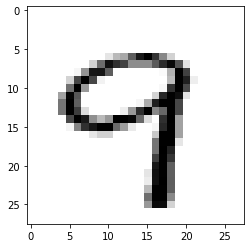

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

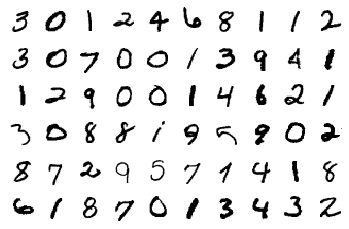

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print("Check {0}",str("1+2"))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  # https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg_loss = 0 
    #l1_crit = nn.L1Loss(size_average=False)
    for param in model.parameters():
      #if param.dim()>1:
      reg_loss +=  torch.sum(abs(param))
        #reg_loss +=  param.norm(1)
        #reg_loss+=l1_crit(param)
    classify_loss = criterion(y_pred,target)

    #factor = 0.0005
    factor = 0.00001
    loss = classify_loss + factor * reg_loss
    #loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR
import datetime

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print(datetime.datetime.now())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
2020-03-08 15:19:04.327777


Loss=0.1605028659105301 Batch_id=468 Accuracy=93.45: 100%|██████████| 469/469 [00:18<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9849/10000 (98.49%)

EPOCH: 1
2020-03-08 15:19:24.593890


Loss=0.1746746003627777 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9878/10000 (98.78%)

EPOCH: 2
2020-03-08 15:19:45.107440


Loss=0.04456665366888046 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9894/10000 (98.94%)

EPOCH: 3
2020-03-08 15:20:05.703053


Loss=0.044255927205085754 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:18<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9881/10000 (98.81%)

EPOCH: 4
2020-03-08 15:20:26.164002


Loss=0.06071942299604416 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9916/10000 (99.16%)

EPOCH: 5
2020-03-08 15:20:46.752248


Loss=0.04584173858165741 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9896/10000 (98.96%)

EPOCH: 6
2020-03-08 15:21:07.335250


Loss=0.05259522795677185 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9914/10000 (99.14%)

EPOCH: 7
2020-03-08 15:21:27.645840


Loss=0.0457787811756134 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9923/10000 (99.23%)

EPOCH: 8
2020-03-08 15:21:48.190196


Loss=0.058067623525857925 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9907/10000 (99.07%)

EPOCH: 9
2020-03-08 15:22:08.659250


Loss=0.02691532112658024 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9893/10000 (98.93%)

EPOCH: 10
2020-03-08 15:22:28.900693


Loss=0.05091387778520584 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9889/10000 (98.89%)

EPOCH: 11
2020-03-08 15:22:49.170465


Loss=0.03735218197107315 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9926/10000 (99.26%)

EPOCH: 12
2020-03-08 15:23:09.547066


Loss=0.02318616211414337 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9911/10000 (99.11%)

EPOCH: 13
2020-03-08 15:23:29.972038


Loss=0.03476574271917343 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9929/10000 (99.29%)

EPOCH: 14
2020-03-08 15:23:50.570810


Loss=0.03098178096115589 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9905/10000 (99.05%)

EPOCH: 15
2020-03-08 15:24:11.291169


Loss=0.0672321766614914 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9919/10000 (99.19%)

EPOCH: 16
2020-03-08 15:24:31.710136


Loss=0.0584045946598053 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9903/10000 (99.03%)

EPOCH: 17
2020-03-08 15:24:52.406689


Loss=0.08561823517084122 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9910/10000 (99.10%)

EPOCH: 18
2020-03-08 15:25:13.224968


Loss=0.033686667680740356 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9928/10000 (99.28%)

EPOCH: 19
2020-03-08 15:25:33.742607


Loss=0.07698927074670792 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9906/10000 (99.06%)

EPOCH: 20
2020-03-08 15:25:54.367843


Loss=0.02375631593167782 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9916/10000 (99.16%)

EPOCH: 21
2020-03-08 15:26:14.834467


Loss=0.0315365195274353 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9922/10000 (99.22%)

EPOCH: 22
2020-03-08 15:26:35.368851


Loss=0.045312341302633286 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9920/10000 (99.20%)

EPOCH: 23
2020-03-08 15:26:55.984055


Loss=0.028527481481432915 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9934/10000 (99.34%)

EPOCH: 24
2020-03-08 15:27:16.456879


Loss=0.01950671523809433 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9919/10000 (99.19%)

EPOCH: 25
2020-03-08 15:27:37.161433


Loss=0.05901136249303818 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9923/10000 (99.23%)

EPOCH: 26
2020-03-08 15:27:57.876505


Loss=0.022586144506931305 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9906/10000 (99.06%)

EPOCH: 27
2020-03-08 15:28:18.406108


Loss=0.02371184155344963 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9924/10000 (99.24%)

EPOCH: 28
2020-03-08 15:28:39.156297


Loss=0.041762907058000565 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9869/10000 (98.69%)

EPOCH: 29
2020-03-08 15:28:59.750587


Loss=0.05034896358847618 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9920/10000 (99.20%)

EPOCH: 30
2020-03-08 15:29:20.374742


Loss=0.04617944359779358 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:18<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9942/10000 (99.42%)

EPOCH: 31
2020-03-08 15:29:41.285941


Loss=0.049209997057914734 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9925/10000 (99.25%)

EPOCH: 32
2020-03-08 15:30:01.565728


Loss=0.04409293457865715 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9938/10000 (99.38%)

EPOCH: 33
2020-03-08 15:30:21.921742


Loss=0.0188506580889225 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 25.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9893/10000 (98.93%)

EPOCH: 34
2020-03-08 15:30:42.682124


Loss=0.050940025597810745 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9918/10000 (99.18%)

EPOCH: 35
2020-03-08 15:31:03.051061


Loss=0.02885514870285988 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9927/10000 (99.27%)

EPOCH: 36
2020-03-08 15:31:23.783211


Loss=0.03309048339724541 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9926/10000 (99.26%)

EPOCH: 37
2020-03-08 15:31:44.395259


Loss=0.027522951364517212 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9934/10000 (99.34%)

EPOCH: 38
2020-03-08 15:32:04.936900


Loss=0.039546214044094086 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9909/10000 (99.09%)

EPOCH: 39
2020-03-08 15:32:25.369815


Loss=0.0330820307135582 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.0268, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

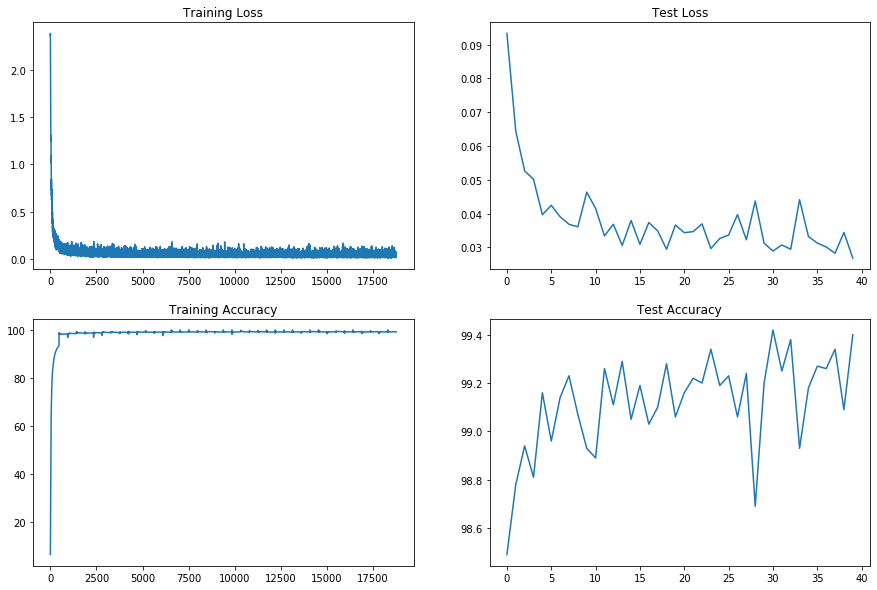

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")